In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import geojsoncontour

In [2]:
DATA_FILE_DIR = "./nasa/"

START_YEAR, END_YEAR = 2010, 2020

NUM_OF_YEARS = END_YEAR - START_YEAR

NUM_OF_MONTHS = 12

NUM_OF_DAYS = {1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6: 30, 7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31}

In [4]:
file = nc.Dataset(DATA_FILE_DIR+'20110101.nc4')

lat = file.variables['lat'][:].filled()
lon = file.variables['lon'][:].filled()
# we will use this mask later
mask = file.variables['AvgSurfT_tavg'][0].mask

LON = len(lon)
LAT = len(lat)

file.close()

In [5]:
def get_tmp(filepath):
    assert os.path.isfile(filepath), '{} does not exist!'.format(filepath)
    
    file = nc.Dataset(filepath)
    temperature = file.variables['AvgSurfT_tavg'][0]
    file.close()
    return temperature.filled(np.nan)

In [6]:
%%time
each_year_HDD = np.ndarray(shape=(NUM_OF_YEARS, LAT, LON))
each_year_CDD = np.ndarray(shape=(NUM_OF_YEARS, LAT, LON))
each_year_MPID = np.ndarray(shape=(NUM_OF_YEARS, LAT, LON))
for year in range(START_YEAR, END_YEAR):
    print(year)
    yearly_temp = np.ndarray(shape=(365, LAT, LON))
    i = 0
    for month in range(1, NUM_OF_MONTHS+1):
        for day in range(1, NUM_OF_DAYS[month]+1):
            date = "{}{:02d}{:02d}".format(year, month, day)
            filepath = DATA_FILE_DIR + date + '.nc4'
            yearly_temp[i] = get_tmp(filepath)
            i += 1
    
    date_HDD = np.where(yearly_temp<291.15, 291.15-yearly_temp, 0) #291.15 K = 18 oC
    date_CDD = np.where(yearly_temp>291.15, yearly_temp-291.15, 0)
    date_MPID = np.where(yearly_temp<253.15, 1, 0) # 253.15 K = -20 oC
    
    each_year_HDD[year-START_YEAR] = date_HDD.sum(axis=0)
    each_year_CDD[year-START_YEAR] = date_CDD.sum(axis=0)
    each_year_MPID[year-START_YEAR] = date_MPID.sum(axis=0)

2010


<timed exec>:15: RuntimeWarning: invalid value encountered in less
<timed exec>:16: RuntimeWarning: invalid value encountered in greater
<timed exec>:17: RuntimeWarning: invalid value encountered in less


2011
2012
2013
2014
2015
2016
2017
2018
2019
Wall time: 3min 27s


In [64]:
avg_HDD = each_year_HDD.mean(axis=0)
avg_CDD = each_year_CDD.mean(axis=0)
avg_MPID = each_year_MPID.mean(axis=0)

max_HDD = each_year_HDD.max(axis=0)
max_CDD = each_year_CDD.max(axis=0)
max_MPID = each_year_MPID.max(axis=0)

In [65]:
avg_score = 100 - 0.005*avg_HDD - 0.5*avg_MPID - 0.004*avg_CDD
worst_score = 100 - 0.005*max_HDD - 0.5*max_MPID - 0.004*max_CDD

In [66]:
avg_score = np.ma.array(avg_score, mask=mask, fill_value=np.nan)
worst_score = np.ma.array(max_score, mask=mask, fill_value=np.nan)

In [67]:
# minmax scaling
scaled_avg_score = 100*(avg_score - np.nanmin(avg_score))/(np.nanmax(avg_score) - np.nanmin(avg_score))
scaled_worst_score = 100*(worst_score - np.nanmin(worst_score))/(np.nanmax(worst_score) - np.nanmin(worst_score))

In [68]:
# levels to draw contour lines at
levels = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

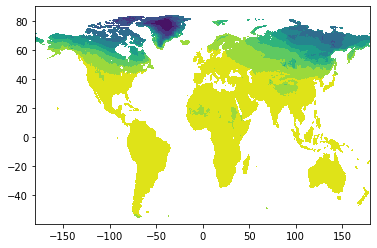

In [69]:
# mesh x and y (lon and lat coordinates)
x_mesh, y_mesh = np.meshgrid(lon, lat)

# z_mesh
z_mesh = scaled_avg_score

# create the contour plot
contourf = plt.contourf(x_mesh, y_mesh, z_mesh, linestyles="None", levels=levels)

In [70]:
os.makedirs("./geojson_files", exist_ok=True)
geojsoncontour.contourf_to_geojson(contourf, geojson_filepath="./geojson_files/scaled_avg_score.geojson")

In [77]:
levels = [-1000, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

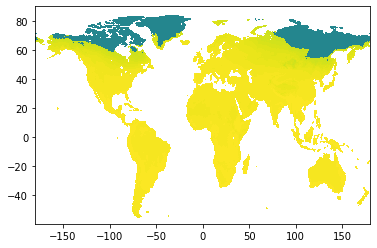

In [78]:
# mesh x and y (lon and lat coordinates)
x_mesh, y_mesh = np.meshgrid(lon, lat)

# z_mesh
z_mesh = avg_score

# create the contour plot
contourf = plt.contourf(x_mesh, y_mesh, z_mesh, linestyles="None", levels=levels)

In [73]:
geojsoncontour.contourf_to_geojson(contourf, geojson_filepath="./geojson_files/avg_score.geojson")

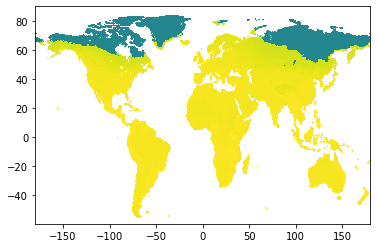

In [74]:
# mesh x and y (lon and lat coordinates)
x_mesh, y_mesh = np.meshgrid(lon, lat)

# z_mesh
z_mesh = worst_score

# create the contour plot
contourf = plt.contourf(x_mesh, y_mesh, z_mesh, linestyles="None", levels=levels)

In [75]:
geojsoncontour.contourf_to_geojson(contourf, geojson_filepath="./geojson_files/worst_score.geojson")